In [1]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.regularizers import l1, l2
from sklearn import ensemble
from sklearn.metrics import roc_auc_score, plot_roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.constraints import max_norm
from xgboost import plot_importance
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import xgboost as xgb

dc_dfs = {}

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        name = filename.split('.')[0]
        dc_dfs[name] = pd.read_csv(os.path.join(dirname, filename))

print(dc_dfs.keys())

/kaggle/input/movielens-20m-dataset/rating.csv
/kaggle/input/movielens-20m-dataset/link.csv
/kaggle/input/movielens-20m-dataset/genome_tags.csv
/kaggle/input/movielens-20m-dataset/genome_scores.csv
/kaggle/input/movielens-20m-dataset/tag.csv
/kaggle/input/movielens-20m-dataset/movie.csv
dict_keys(['rating', 'link', 'genome_tags', 'genome_scores', 'tag', 'movie'])


In [2]:
def gen_df_selec(dc):
    # Tomaremos un subconjunto de los datos. La base es grande, 
    # entonces inicialmente concentremonos en construir un código
    
    s_nratings_x_user = dc_dfs['rating'].groupby('userId').agg({'movieId': lambda x: x.size})
    thres_min = s_nratings_x_user['movieId'].quantile(0.47)
    thres_max = s_nratings_x_user['movieId'].quantile(0.50)
    cond_range = ((s_nratings_x_user['movieId']>=thres_min)&
                  (s_nratings_x_user['movieId']<=thres_max))
    
    s_nratings_x_user_selec = s_nratings_x_user[cond_range]
    
    ls_selec = s_nratings_x_user_selec.index.tolist()
    
    #df = dc['rating'][ dc['rating']['userId'].isin(ls_selec)]
    df = dc['rating'].sample(50_000)
    
    print( " df = dc['rating'][ dc['rating']['userId'].isin(ls_selec)] ", df.shape)
    
    # Pegamos el genero de cada pelicula
    df = df.merge( dc['movie'], on='movieId' , how='inner')
    
    print( " df.merge( dc['movie'], on='movieId' , how='inner') ", df.shape)
    
    # Generamos la variable respuesta
    df['y'] = df ['rating'].map(lambda x: {True: 1, False:0}[x>=4])
    
    # Hasta aquí, no nos sirven las siguientes variables, por lo que 
    # las tiraremos para poder probar un modelo de línea base
    #df.drop(['rating', 'timestamp', 'title'], axis=1, inplace=True)
    df.drop(['title'], axis=1, inplace=True)

    return df

# Armemos el df inicial:
# 1.- filtremos para unicamente trabajar con mil personas
df_selec = gen_df_selec(dc_dfs)
df_selec_head = df_selec.head(1_000)
print(df_selec_head.head())
print('df_selec.shape', df_selec.shape)

 df = dc['rating'][ dc['rating']['userId'].isin(ls_selec)]  (50000, 4)
 df.merge( dc['movie'], on='movieId' , how='inner')  (50000, 6)
   userId  movieId  rating            timestamp  \
0   76542     1200     5.0  1999-12-14 00:35:29   
1   56120     1200     3.5  2008-10-24 13:22:49   
2   74123     1200     5.0  2002-07-12 11:15:07   
3   68083     1200     4.0  2006-12-26 18:53:56   
4   81585     1200     2.0  2000-07-13 23:39:07   

                           genres  y  
0  Action|Adventure|Horror|Sci-Fi  1  
1  Action|Adventure|Horror|Sci-Fi  0  
2  Action|Adventure|Horror|Sci-Fi  1  
3  Action|Adventure|Horror|Sci-Fi  1  
4  Action|Adventure|Horror|Sci-Fi  0  
df_selec.shape (50000, 6)


In [3]:
{g for s in df_selec['genres'] for g in s.split('|')}

{'Action',
 'Adventure',
 'Animation',
 'Children',
 'Comedy',
 'Crime',
 'Documentary',
 'Drama',
 'Fantasy',
 'Film-Noir',
 'Horror',
 'IMAX',
 'Musical',
 'Mystery',
 'Romance',
 'Sci-Fi',
 'Thriller',
 'War',
 'Western'}

In [4]:
def train_test_split_custom(X, y, test_size=0.2):
    rows_train = int( 0.8*X.shape[0]) 
    (X_train, X_test, 
     Y_train, Y_test) = (X.iloc[:rows_train,:], X.iloc[rows_train:,:], 
                         y.iloc[:rows_train], y.iloc[rows_train:])
    
    return X_train, X_test, Y_train, Y_test

def gen_cars_users(X_train):
    # Tomemos el rating promedio que hace cada usuario
    rating_promedio = (X_train.groupby('userId').agg({'rating':np.mean}).
                       rename(columns={'rating':'user_rating_promedio'}))
    
    rating_promedio2 = (rating_promedio['user_rating_promedio']*rating_promedio['user_rating_promedio']).to_frame()
    rating_promedio2.columns = ['user_rating_promedio^2']
    
    rating_min = (X_train.groupby('userId').agg({'rating':np.min}).
                  rename(columns={'rating':'user_rating_min'}))
    rating_max = (X_train.groupby('userId').agg({'rating':np.max}).
                  rename(columns={'rating':'user_rating_max'}))
    rating_mediana = (X_train.groupby('userId').agg({'rating':np.median}).
                      rename(columns={'rating':'user_rating_mediana'}))
    rating_rango = (X_train.groupby('userId').agg({'rating':lambda x: x.max() - x.min()}).
                      rename(columns={'rating':'user_rating_rango'}))
    rating_std = (X_train.groupby('userId').agg({'rating':np.std}).
                      rename(columns={'rating':'user_rating_std'}))
    
    nmovies = (X_train.groupby('userId').agg({'rating':lambda x: x.size}).
                      rename(columns={'rating':'user_nmovies_rating'}))
    
    nmovies2 = ((nmovies['user_nmovies_rating']*nmovies['user_nmovies_rating'])).to_frame()
    nmovies2.columns=['user_nmovies_rating^2']
    
    nmovies_high = (X_train.groupby('userId').agg({'rating':lambda x: (x>=4).sum()}).
                      rename(columns={'rating':'user_nmovies_high'}))
    nmovies_low = (X_train.groupby('userId').agg({'rating':lambda x: (x<4).sum()}).
                      rename(columns={'rating':'user_nmovies_low'}))
    
    def rango(s):
        return s.max() - s.min()
    
    st_genres = {'Western', 'Romance', 'Animation', 'Sci-Fi', 'Horror', 
              'Fantasy', 'Film-Noir', 'War', 'Drama', 'Thriller', 
              'Musical', 'IMAX', 'Children', 'Documentary', 'Action', 
              'Comedy', 'Adventure', 'Crime', 'Mystery', 
              '(no genres listed)'}

    ls_ind_x_genre = []
    
    for genre in st_genres:
        s1 = X_train.groupby('userId').apply(lambda df: np.mean(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s1.name = f'user_{genre}_mean_x_userId'
        s2 = X_train.groupby('userId').apply(lambda df: np.min(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s2.name = f'user_{genre}_min_x_userId'
        s3 = X_train.groupby('userId').apply(lambda df: np.max(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s3.name = f'user_{genre}_max_x_userId'
        s4 = X_train.groupby('userId').apply(lambda df: np.median(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s4.name = f'user_{genre}_median_x_userId'
        s5 = s3-s2
        s5.name = f'user_{genre}_range_x_userId'
        ls_ind_x_genre.extend([s1, s2, s3, s4, s5])
    
    inds_x_gen = pd.concat(ls_ind_x_genre,axis=1)
    
     # generamos pares de géneros
    genrex2= {(g1, g2) if g1<g2 else (g2, g1)
              for g1 in st_genres for g2 in st_genres if g1!=g2}
    
    ls_ind_x_genrex2 = []
    
    for g1, g2 in genrex2:
        genre = '|'.join((g1, g2))
        s1 = X_train.groupby('userId').apply(lambda df: np.mean(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s1.name = f'user_{genre}_mean_x_userId'
        s2 = X_train.groupby('userId').apply(lambda df: np.min(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s2.name = f'user_{genre}_min_x_userId'
        s3 = X_train.groupby('userId').apply(lambda df: np.max(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s3.name = f'user_{genre}_max_x_userId'
        s4 = X_train.groupby('userId').apply(lambda df: np.median(df[df[genre]==1]['rating']) if (df[genre]==1).sum()>1 else np.nan)
        s4.name = f'user_{genre}_median_x_userId'
        s5 = s3-s2
        s5.name = f'user_{genre}_range_x_userId'
        ls_ind_x_genrex2.extend([s1, s2, s3, s4, s5])
    
    inds_x_genx2 = pd.concat(ls_ind_x_genrex2,axis=1)
    
    return pd.concat([rating_promedio,rating_promedio2, rating_min, rating_max, rating_mediana, 
                     rating_rango,rating_std, nmovies, nmovies2, nmovies_high, nmovies_low, inds_x_gen,
                      inds_x_genx2],
                     axis=1)

def gen_cars_movies_genres(X_train, topN=None):
    if topN:
        # solo seleccionar la lista de los 100 generos
        # con más registros, esto porque el código
        # se alenta demasiado
        topN_genre = X_train.groupby('genres').agg({'rating': lambda x: x.size})
        topN_genre = topN_genre.sort_values('rating',ascending=False)
        topN_genre = topN_genre.iloc[:topN]
        topN_genre = topN_genre.index.tolist()
        X_train = X_train[X_train['genres'].isin(topN_genre)]
    
    rating_promedio = (X_train.groupby('genres').agg({'rating':np.mean}).
                       rename(columns={'rating':'genres_rating_promedio'}))
    rating_min = (X_train.groupby('genres').agg({'rating':np.min}).
                  rename(columns={'rating':'genres_rating_min'}))
    rating_max = (X_train.groupby('genres').agg({'rating':np.max}).
                  rename(columns={'rating':'genres_rating_max'}))
    rating_mediana = (X_train.groupby('genres').agg({'rating':np.median}).
                      rename(columns={'rating':'genres_rating_mediana'}))
    rating_rango = (X_train.groupby('genres').agg({'rating':lambda x: x.max() - x.min()}).
                      rename(columns={'rating':'genres_rating_rango'}))
    rating_std = (X_train.groupby('genres').agg({'rating':np.std}).
                      rename(columns={'rating':'genres_rating_std'}))    
    nusers = (X_train.groupby('genres').agg({'rating':lambda x: x.size}).
                      rename(columns={'rating':'genres_nusers_rating'}))
    nusers_high = (X_train.groupby('genres').agg({'rating':lambda x: (x>=4).sum()}).
                      rename(columns={'rating':'genres_nusers_high'}))
    nusers_low = (X_train.groupby('genres').agg({'rating':lambda x: (x<4).sum()}).
                      rename(columns={'rating':'genres_nusers_low'}))
    rating_prom = (X_train.groupby('genres').agg({'rating':lambda x: (x>=4).sum()/x.size}).
                      rename(columns={'rating':'rating1_0_prom_x_genre'}))

    return pd.concat([rating_promedio, rating_min, rating_max, rating_mediana, 
        rating_rango, rating_std, nusers, nusers_high, nusers_low], axis=1)

def gen_cars_single_genres(X_train):
    # Definimos para las 100 películas más vistas
    
    st_genres = {'Western', 'Romance', 'Animation', 'Sci-Fi', 'Horror', 
                  'Fantasy', 'Film-Noir', 'War', 'Drama', 'Thriller', 
                  'Musical', 'IMAX', 'Children', 'Documentary', 'Action', 
                  'Comedy', 'Adventure', 'Crime', 'Mystery', 
                  '(no genres listed)'}
    
    ls_series_genre = []
    for genre in st_genres:
        x_train_genre = X_train[X_train[genre]==1]
        dc_genre_inds = {f'rating_promedio':x_train_genre['rating'].mean(), 
                         f'rating_min':x_train_genre['rating'].min(), 
                         f'rating_max':x_train_genre['rating'].max(), 
                         f'rating_mediana':np.median(x_train_genre['rating']), 
                         f'rating_rango':x_train_genre['rating'].max() - x_train_genre['rating'].min(), 
                         f'rating_std':x_train_genre['rating'].std(), 
                         f'nusers':x_train_genre.shape[0],
                         f'nusers_high':(x_train_genre['rating']>=4).sum(),
                         f'nusers_low':(x_train_genre['rating']<4).sum(),
                         f'rating1_0_prom':(x_train_genre['rating']>=4).sum()/(x_train_genre.shape[0])}
        
        s_genre = pd.Series(dc_genre_inds)
        s_genre.name=genre
        ls_series_genre.append(s_genre)
    
    df_inds_single_genres = pd.concat(ls_series_genre, axis=1).T
    
    return df_inds_single_genres

# Generamos función para crear los dataframes para entrenar/validar el modelo
def gen_Xy(df):
    #col_y = 'y'

    # Consideraremos que los ratings son temporales, y que 
    # el tiempo es una variable que influye en el rating que 
    # hace el usuario. Entonces ordenaremos el dataframe, 
    # y tomaremos el primer 80% de registros como entrenamiento
    # y el último 20% de registros como validación/prueba
    df.sort_values(['userId', 'timestamp'], inplace=True)
    
    X_train, X_test, Y_train, Y_test = [pd.DataFrame() for _ in range(4)]
    
    # Generamos el conjunto de entrenamiento y el de prueba
    for _, df_user in df.groupby('userId'):
        # Sabemos que la ultima variable es la variable respuesta (y)
        X = df_user.iloc[:,:-1]
        y = df_user.iloc[:,-1]
        
        #(X_train_user, X_test_user,
        #Y_train_user, Y_test_user) = train_test_split(X, y, test_size=0.2,
        #                                                    random_state=1)
    
        (X_train_user, X_test_user,
        Y_train_user, Y_test_user) = train_test_split_custom(X, y, test_size=0.2)
    
    
        X_train = pd.concat([X_train, X_train_user])
        X_test = pd.concat([X_test, X_test_user])
        
        Y_train = pd.concat([Y_train, Y_train_user])
        Y_test = pd.concat([Y_test, Y_test_user])
    
    # Hasta este punto, ya tenemos dividido nuestro conjunto 
    # de entrenamiento y de prueba. Los uniremos, tendiendo siempre
    # presente que los registros son el conjunto de entrenamiento
    # y los ultimos son el conjunto de prueba      

    all_data = pd.concat([X_train, X_test])    

    #========== INGENIERÍA DE CARACTERÍSTICAS ==========
    
    # Generamos dummies de categorías de películas.
    # Como las categorías son contadas, podemos hacerlo con un ciclo sin mayor 
    # dificultad
    st_genres = {'Western', 'Romance', 'Animation', 'Sci-Fi', 'Horror', 
                  'Fantasy', 'Film-Noir', 'War', 'Drama', 'Thriller', 
                  'Musical', 'IMAX', 'Children', 'Documentary', 'Action', 
                  'Comedy', 'Adventure', 'Crime', 'Mystery', 
                  '(no genres listed)'}
    
    for genre in st_genres:
        all_data[genre] = all_data['genres'].map(lambda x: 1 if genre in x else 0)
    
    # generamos pares de géneros
    genrex2= {(g1, g2) if g1<g2 else (g2, g1)
              for g1 in st_genres for g2 in st_genres if g1!=g2}
    
    for g1, g2 in genrex2:
        all_data['|'.join((g1, g2))] = all_data['genres'].map(lambda x: 1 if g1 in x and g2 in x else 0)
    
    # Imprimimos todas las columnas hasta aquí
    print('='*20, 'CARACTERÍSTICAS GENEROS', '='*20)
    print(all_data.columns.tolist())
     
    # Características a nivel usuario:
    cars_user =  gen_cars_users(all_data[:X_train.shape[0]])
    
    print('='*20, 'CARACTERÍSTICAS USUARIO', '='*20)
    print(cars_user.head())
    
    # Pegamos las características nivel usuario
    all_data = all_data.merge(cars_user, left_on='userId', right_index=True, how='left')
    
    print('='*20, 'CARACTERÍSTICAS GENEROS PELÍCULA', '='*20)
    cars_movies = gen_cars_movies_genres(all_data[:X_train.shape[0]], topN=100)
    #gen_cars_movies_genres(X_train, topN=None)
    
    print(cars_movies.head())

    all_data = all_data.merge(cars_movies, left_on='genres', right_index=True, how='left')
    
    # En el caso en el que ocuparemos el top100 de generos, 
    # existe la posibilidad de que existan nulos, por lo tanto, 
    # imputar la mediana a todos los nulos.
    # IMMPUTAR MEDIANA A VALORES NULOS DE LAS COLUMNAS QUE ACABAMOS
    # DE PEGAR
    for col in cars_movies:
        all_data.loc[all_data[col].isnull(),col] = np.median(cars_movies[col])
    
    print('='*20, 'CARACTERÍSTICAS GENEROS (ÚNICOS) PELÍCULA', '='*20)
    cars_single_genres = gen_cars_single_genres(all_data[:X_train.shape[0]])
    print(cars_single_genres)
    
    # Pegamos las características nivel lista de generos: esto lo haremos como sigue
    # Multiplicamos por si el usuario ha visto el género
    for genre in st_genres:
        for col in cars_single_genres:
            all_data[f'{genre}_{col}'] = all_data[genre] * cars_single_genres.loc[genre,col]

    # Tiramos la columna genre, pues ya la hemos utilizado para generar
    # las indicadoras de genero (s) de la película
    all_data.drop('genres', axis=1, inplace=True)

    # Tiramos userId, movieId, hasta aquí ya no nos sirven
    all_data.drop(['rating', 'userId', 'movieId', 'timestamp'], axis=1, inplace=True)
    
    # Columnas finales
    print('Columnas finales:', all_data.columns.tolist())
    
    X_train = all_data.iloc[: X_train.shape[0],:]
    X_test = all_data.iloc[X_train.shape[0]:,:]
    
    return X_train, X_test, Y_train, Y_test

X_train, X_test, Y_train, Y_test = gen_Xy(df_selec)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:217: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


==================== CARACTERÍSTICAS GENEROS ====================
['userId', 'movieId', 'rating', 'timestamp', 'genres', 'Horror', 'Drama', 'Western', 'Fantasy', 'IMAX', 'Sci-Fi', 'Adventure', 'Children', 'Comedy', 'Thriller', 'Musical', 'Mystery', 'War', 'Action', 'Animation', 'Film-Noir', '(no genres listed)', 'Romance', 'Crime', 'Documentary', 'Comedy|Crime', 'IMAX|War', '(no genres listed)|Musical', 'Documentary|Drama', 'Drama|IMAX', 'Animation|Children', 'Crime|Film-Noir', 'Fantasy|Western', 'Comedy|Horror', 'Mystery|Sci-Fi', 'Adventure|Comedy', 'Horror|War', 'IMAX|Mystery', 'Comedy|IMAX', 'Animation|IMAX', 'Action|Adventure', 'Romance|War', 'Musical|Mystery', 'Adventure|Musical', '(no genres listed)|Comedy', 'Action|Mystery', 'Crime|Fantasy', 'Film-Noir|Horror', 'Comedy|Sci-Fi', 'Drama|Mystery', 'Animation|Sci-Fi', 'Mystery|Western', 'Crime|Thriller', 'Crime|Horror', 'Crime|Documentary', 'Action|Comedy', 'Film-Noir|IMAX', 'Animation|Musical', 'Musical|Sci-Fi', 'Crime|IMAX', 'Anim

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:256: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


                    rating_promedio  rating_min  rating_max  rating_mediana  \
Horror                     3.253840         0.5         5.0             3.5   
Drama                      3.594229         0.5         5.0             4.0   
Western                    3.623967         0.5         5.0             4.0   
Fantasy                    3.412255         0.5         5.0             3.5   
IMAX                       3.595166         0.5         5.0             4.0   
Sci-Fi                     3.374752         0.5         5.0             3.5   
Adventure                  3.419420         0.5         5.0             3.5   
Children                   3.311524         0.5         5.0             3.5   
Comedy                     3.332874         0.5         5.0             3.5   
Thriller                   3.437064         0.5         5.0             3.5   
Musical                    3.474966         0.5         5.0             3.5   
Mystery                    3.596538         0.5     

In [5]:
X_train.head()

,Horror,Drama,Western,Fantasy,IMAX,Sci-Fi,Adventure,Children,Comedy,Thriller,...,Documentary_rating_promedio,Documentary_rating_min,Documentary_rating_max,Documentary_rating_mediana,Documentary_rating_rango,Documentary_rating_std,Documentary_nusers,Documentary_nusers_high,Documentary_nusers_low,Documentary_rating1_0_prom
1819,0,0,0,0,0,0,0,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16188,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19517,0,1,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
13827,0,0,0,0,0,0,0,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32089,0,0,0,0,0,1,1,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def calcula_error(mod, nom, X, y, tipo='train'):
    # Calculamos la predicción del modelo
    print('='*10, tipo, '='*10)
    y_hat = mod.predict_proba(X)[:,1]
    
    r_auc_s = roc_auc_score(y, y_hat)
    
    print("ROC AUC score: {:.4f}".format(r_auc_s))
    
    plot_roc_curve(mod, X, y)
    
    plt.title(rf"Tipo: {tipo}\n{nom}")
    
    plt.show()
    
    return r_auc_s


def fn_procesa_modelo(mod, nom, X_train, y_train, X_test, y_test):
    global df_res
    print('='*20, 'Modelo:', nom, '='*20)
    btime = datetime.now()
    print('empieza el entrenamiento del modelo:', btime)
    mod.fit(X_train, y_train)
    etime = datetime.now()
    print('Termina  el entrenamiento del modelo:', etime)
    print('Tiempo que tomó el entrenamiento:', etime - btime)

    print('Error de entrenamiento:')    
    r_auc_s_train = calcula_error(mod,nom,  X_train, y_train, tipo='train')

    print('Error de prueba:')
    r_auc_s_test = calcula_error(mod, nom, X_test, y_test, tipo='test')
    
    df_mod = pd.DataFrame({'modelo':[nom], 
                           'roc auc score - train':[r_auc_s_train],
                           'roc auc score - test':[r_auc_s_test], 
                          })
    return df_mod

X_train.shape: (16221, 1480)
X_test.shape: (33779, 1480)
==================== Modelo: mdepth_3_nest_300_csbt_0.50_ss_0.45 ====================
empieza el entrenamiento del modelo: 2021-12-14 21:36:44.082680


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[21:36:44] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Termina  el entrenamiento del modelo: 2021-12-14 21:37:01.780124
Tiempo que tomó el entrenamiento: 0:00:17.697444
Error de entrenamiento:
========== train ==========
ROC AUC score: 0.9590


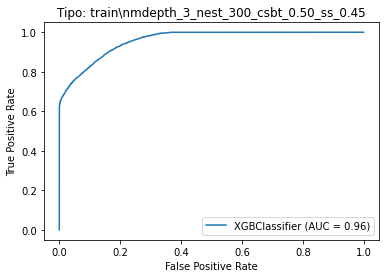

Error de prueba:
========== test ==========
ROC AUC score: 0.5570


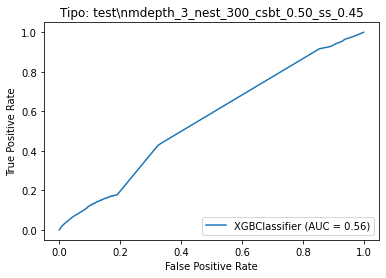

                                modelo  roc auc score - train  \
0  mdepth_3_nest_300_csbt_0.50_ss_0.45               0.959023   

   roc auc score - test  
0              0.556974  
==================== Modelo: mdepth_3_nest_400_csbt_0.50_ss_0.45 ====================
empieza el entrenamiento del modelo: 2021-12-14 21:37:04.977856


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[21:37:05] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Termina  el entrenamiento del modelo: 2021-12-14 21:37:24.859255
Tiempo que tomó el entrenamiento: 0:00:19.881399
Error de entrenamiento:
========== train ==========
ROC AUC score: 0.9595


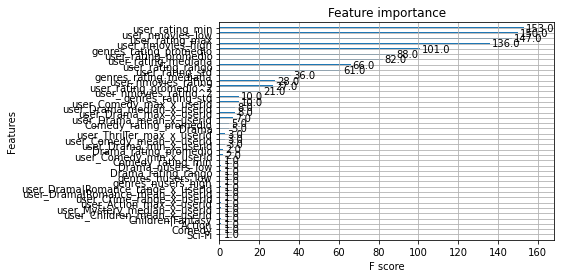

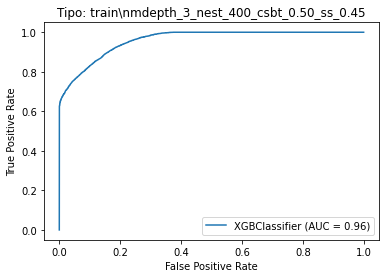

Error de prueba:
========== test ==========
ROC AUC score: 0.5716


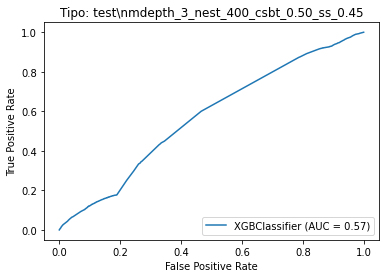

                                modelo  roc auc score - train  \
0  mdepth_3_nest_300_csbt_0.50_ss_0.45               0.959023   
0  mdepth_3_nest_400_csbt_0.50_ss_0.45               0.959531   

   roc auc score - test  
0              0.556974  
0              0.571637  
==================== Modelo: mdepth_4_nest_300_csbt_0.50_ss_0.45 ====================
empieza el entrenamiento del modelo: 2021-12-14 21:37:28.235480


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[21:37:28] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Termina  el entrenamiento del modelo: 2021-12-14 21:37:45.070402
Tiempo que tomó el entrenamiento: 0:00:16.834922
Error de entrenamiento:
========== train ==========
ROC AUC score: 0.9614


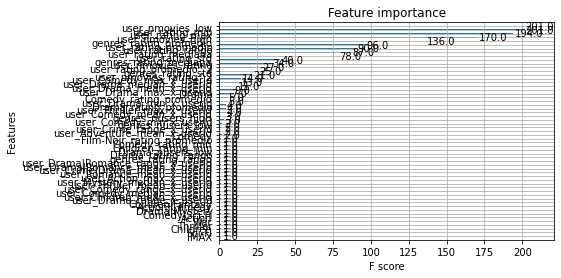

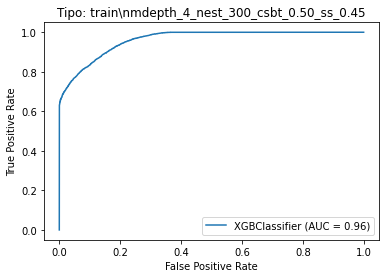

Error de prueba:
========== test ==========
ROC AUC score: 0.5705


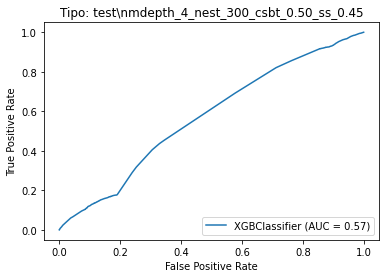

                                modelo  roc auc score - train  \
0  mdepth_3_nest_300_csbt_0.50_ss_0.45               0.959023   
0  mdepth_3_nest_400_csbt_0.50_ss_0.45               0.959531   
0  mdepth_4_nest_300_csbt_0.50_ss_0.45               0.961433   

   roc auc score - test  
0              0.556974  
0              0.571637  
0              0.570453  
==================== Modelo: mdepth_4_nest_400_csbt_0.50_ss_0.45 ====================
empieza el entrenamiento del modelo: 2021-12-14 21:37:49.061524


/opt/conda/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


[21:37:49] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Termina  el entrenamiento del modelo: 2021-12-14 21:38:11.937158
Tiempo que tomó el entrenamiento: 0:00:22.875634
Error de entrenamiento:
========== train ==========
ROC AUC score: 0.9621


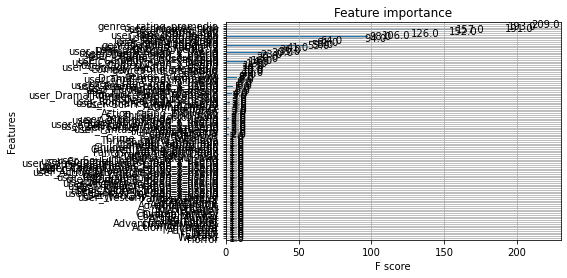

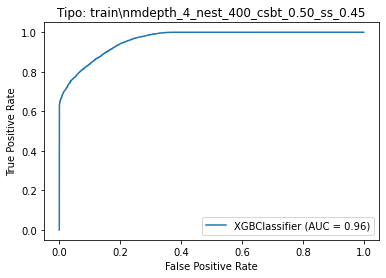

Error de prueba:
========== test ==========
ROC AUC score: 0.5708


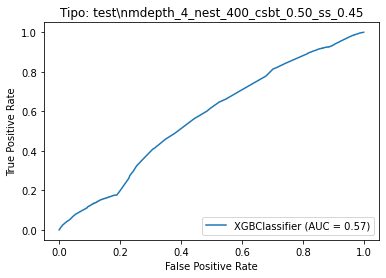

                                modelo  roc auc score - train  \
0  mdepth_3_nest_300_csbt_0.50_ss_0.45               0.959023   
0  mdepth_3_nest_400_csbt_0.50_ss_0.45               0.959531   
0  mdepth_4_nest_300_csbt_0.50_ss_0.45               0.961433   
0  mdepth_4_nest_400_csbt_0.50_ss_0.45               0.962137   

   roc auc score - test  
0              0.556974  
0              0.571637  
0              0.570453  
0              0.570767  


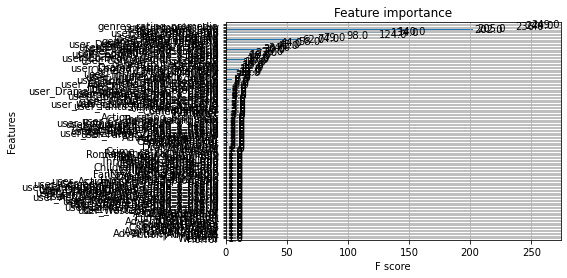

In [7]:
#X_train, X_test, y_train, y_test, pred = carga_Xy()

# Verificamos el tamaño de los conjutnos
print('X_train.shape:', X_train.shape)
print('X_test.shape:', X_test.shape)

df_res_total = pd.DataFrame()

for mdepth in [3, 4]:
    for n_est in [300, 400]:
        for csbt in [0.5]:
            for ss in [0.45]: #, 0.5]:
                xgb_nest = xgb.XGBClassifier(objective='binary:logistic',
                                             colsample_bytree=csbt,
                                             gamma=0.0,
                                             learning_rate=0.01,
                                             max_depth=mdepth,
                                             min_child_weight=1.5,
                                             n_estimators=n_est,
                                             reg_alpha=0.9,
                                             reg_lambda=0.6,
                                             subsample=ss, # subimos esto
                                             seed=42,
                                             silent=1, 
                                            eval_metric='error')
                
                nom_modelo = f'mdepth_{mdepth}_nest_{n_est}_csbt_{csbt:.2f}_ss_{ss:.2f}'
                df_res = fn_procesa_modelo(xgb_nest, nom_modelo, 
                                  X_train, Y_train, X_test, Y_test)

                df_res_total = pd.concat([df_res_total, df_res])
                
                plot_importance(xgb_nest)
                
                print(df_res_total)

In [8]:
df_res_total

,modelo,roc auc score - train,roc auc score - test
0,mdepth_3_nest_300_csbt_0.50_ss_0.45,0.959023,0.556974
0,mdepth_3_nest_400_csbt_0.50_ss_0.45,0.959531,0.571637
0,mdepth_4_nest_300_csbt_0.50_ss_0.45,0.961433,0.570453
0,mdepth_4_nest_400_csbt_0.50_ss_0.45,0.962137,0.570767
